# Figure S1: Cluster proportions stacked barplots

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns

import sys
sys.path.append("/code/")
from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_erode as cerd
from thalamus_merfish_analysis import diversity_metrics as divmet
from thalamus_merfish_analysis import diversity_plots as dplot

from matplotlib import rcParams
# set to Illustrator-compatible font type
rcParams['pdf.fonttype'] = 42
# set font size for plots to AIND minimal size
rcParams['font.size'] = 7

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline') 

## Load data

In [2]:
# Load cell metadata
obs_th = abc.load_standard_thalamus(data_structure='obs')

In [3]:
# Load the CCF structures image
ccf_images = abc.get_ccf_labels_image()

# erode ccf structures to correct for boundary effects
parcellation_level = 'structure'
obs_erode, _ = cerd.label_cells_by_eroded_ccf(
                                            obs_th, 
                                            ccf_images,
                                            ccf_level=parcellation_level,
                                            distance_px=5, # default is erosion by 5px (5um)
                                            )

# There is poor alignment in section 6.6 between PF celltypes and the PF CCF structure
# So, we'll set all cells in section 6.6 to 'unassigned' CCF structure
obs_erode.loc[lambda df: df['z_section']==6.6, cerd._ERODED_CCF_INDEX_COL] = np.nan#'unassigned'

# generate metrics for the eroded CCF structure
ccf_label=f'parcellation_{parcellation_level}_eroded'
th_ccf_metrics = divmet.calculate_diversity_metrics(obs_erode, ccf_label=ccf_label)

# regions_to_plot = dplot.TH_DIVERSITY_REGIONS

## Set figure saving behavior

In [4]:
results_dir = '../../results'

## Plots

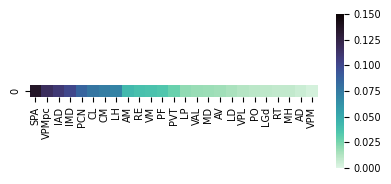

In [15]:
# Rank thalamic nuclei by their diversity, as measured by the # of unique clusters per cell (CPC)
# We'll use this to set the order of the y-axis for all 3 taxonomy levels
taxonomy_level = 'cluster'
metrics_to_sort_by = th_ccf_metrics.loc[dplot.TH_DIVERSITY_REGIONS,:]
cpc_sorted_metrics = metrics_to_sort_by.sort_values(
                                by=[f'count_norm2cells_{taxonomy_level}'],
                                ascending=False
                                )
cpc_sorted_regions = cpc_sorted_metrics.index

# plot 
fig_cpc_rank, ax = plt.subplots(figsize=(4.65,2))
cmap_cpc = sns.color_palette("mako_r", as_cmap=True)
# setting vmin, vmax to match Fig. 2F
fig_cpc_hm = sns.heatmap(
                        [cpc_sorted_metrics[f'count_norm2cells_{taxonomy_level}'].values],
                        square=True,
                        vmin=0, 
                        vmax=0.15,
                        cmap=cmap_cpc, #'PuBuGn',#'YlGnBu',
                        xticklabels=cpc_sorted_regions,
                        ax=ax)

fig_cpc_rank.savefig(f'{results_dir}/figS2_diversity_rank_1Dheatmap_unique_clusters_per_nucleus.pdf', 
                     transparent=True, bbox_inches='tight')

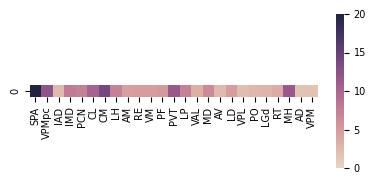

In [19]:
cmap_isi = sns.color_palette("ch:start=-.3,rot=.6", as_cmap=True)

# plot 
fig_isi_rank, ax = plt.subplots(figsize=(4.65,2))
# log transforming just to make the colormap more divergent
sns.heatmap(
            [cpc_sorted_metrics[f'inverse_simpsons_{taxonomy_level}'].values],
            square=True, 
            vmin=0,
            vmax=20,
            cmap=cmap_isi, #'PuBuGn',#'YlGnBu',
            xticklabels=cpc_sorted_regions,
            ax=ax)

fig_isi_rank.savefig(f'{results_dir}/figS2_diversity_rank_1Dheatmap_cpcOrder_isiCmap.pdf', 
                     transparent=True, bbox_inches='tight')

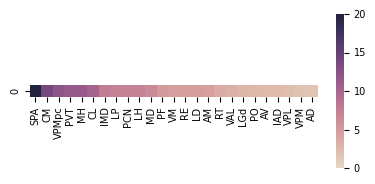

In [20]:
# Rank thalamic nuclei by their diversity, as measured by the inverse simpson's index (ISI)
# We'll use this to set the order of the y-axis for all 3 taxonomy levels
taxonomy_level = 'cluster'
metrics_to_sort_by = th_ccf_metrics.loc[dplot.TH_DIVERSITY_REGIONS,:]
isi_sorted_metrics = metrics_to_sort_by.sort_values(
                                by=[f'inverse_simpsons_{taxonomy_level}'],
                                ascending=False
                                )
isi_sorted_regions = isi_sorted_metrics.index

# plot 
fig_isi_rank, ax = plt.subplots(figsize=(4.65,2))
# log transforming just to make the colormap more divergent
sns.heatmap(
    # np.log(
    [isi_sorted_metrics[f'inverse_simpsons_{taxonomy_level}'].values],#),
            square=True, 
            vmin=0,
            vmax=20,
            cmap=cmap_isi, #'PuBuGn',#'YlGnBu',
            xticklabels=isi_sorted_regions,
            ax=ax)

fig_isi_rank.savefig(f'{results_dir}/figS2_diversity_rank_1Dheatmap_isi_nuclei_vs_cluster.pdf', 
                     transparent=True, bbox_inches='tight')

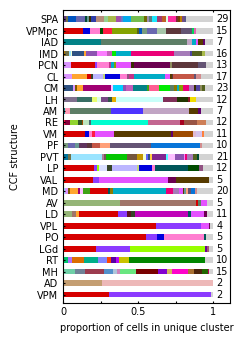

In [21]:
# cluster proportions
taxonomy_level = 'cluster'
fig_bp_cluster = dplot.barplot_stacked_proportions(
    obs_erode, 
    taxonomy_level, 
    th_ccf_metrics, 
    legend=False, 
    min_cell_frac=0.01,  # lump subclasses that are <=1% of cells in that region into "other" category 
                        # also considered: min_cell_frac=0.05 
    ordered_regions=cpc_sorted_regions, #isi_sorted_regions,
    orientation='horizontal',
)
fig_bp_cluster.set_size_inches(2.15,3.8)
fig_bp_cluster.gca().tick_params(length=0.02*72)

ax_cluster = fig_bp_cluster.gca()
xticklabels_cluster = [x.get_text() for x in ax_cluster.get_xticklabels()]

fig_bp_cluster.savefig(f'{results_dir}/figS2_nuclei_diversity_barplot_ordered-isi-cluster_{taxonomy_level}.pdf', 
                       transparent=True, bbox_inches='tight')

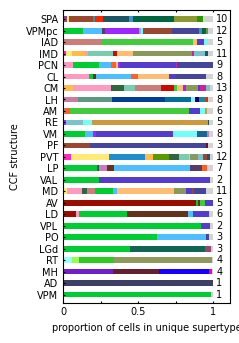

In [22]:
# supertype proportions
taxonomy_level = 'supertype'
fig_bp_supertype = dplot.barplot_stacked_proportions(
    obs_erode, 
    taxonomy_level, 
    th_ccf_metrics, 
    legend=False, 
    min_cell_frac=0.01, # lump subclasses that are <=1% of cells in that region into "other" category 
                        # also considered: min_cell_frac=0.05 
    ordered_regions=cpc_sorted_regions, #isi_sorted_regions,
    orientation='horizontal',
)
fig_bp_supertype.set_size_inches(2.15,3.8)
fig_bp_supertype.gca().tick_params(length=0.02*72)

# alternative: order the CCF regions for subclass & cluster plots using the 
# order of regions from sorting by supertype diversity
ax_supertype = fig_bp_supertype.gca()
xticklabels_supertype = [x.get_text() for x in ax_supertype.get_xticklabels()]

fig_bp_supertype.savefig(f'{results_dir}/figS2_nuclei_diversity_barplot_ordered-isi-cluster_{taxonomy_level}.pdf', 
                         transparent=True, bbox_inches='tight')

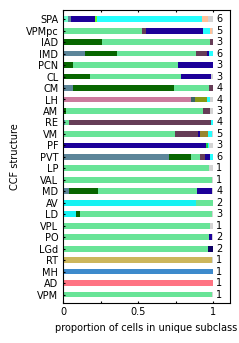

In [23]:
# subclass proportions
taxonomy_level = 'subclass'
fig_bp_subclass = dplot.barplot_stacked_proportions(
    obs_erode, 
    taxonomy_level, 
    th_ccf_metrics, 
    legend=False, 
    min_cell_frac=0.01,  # lump subclasses that are <=1% of cells in that region into "other" category 
                        # also considered: min_cell_frac=0.05 
    ordered_regions=cpc_sorted_regions, #isi_sorted_regions,
    orientation='horizontal',
)
fig_bp_subclass.set_size_inches(2.15,3.8)
fig_bp_subclass.gca().tick_params(length=0.02*72)

ax_subclass = fig_bp_subclass.gca()
xticklabels_subclass = [x.get_text() for x in ax_subclass.get_xticklabels()]

fig_bp_subclass.savefig(f'{results_dir}/figS2_nuclei_diversity_barplot_ordered-isi-cluster_{taxonomy_level}.pdf', 
                        transparent=True, bbox_inches='tight')